# Machine Learning Project: Key Detection
Authors: Zach Hayes, Matt Gaetano, Max Ivry

Course: CS3540


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE

from keras.api.utils import to_categorical
from keras.api.models import Sequential
from keras.api.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D
from keras.api.regularizers import L2
from keras.api.callbacks import EarlyStopping
from keras.api import optimizers

### Gather Training and Testing Data
Data cleaning and feature extraction occured earlier in process. See clean.ipynb

In [6]:
def retrieve_data(square_data = False):
    train_df = pd.read_json("train.json", lines=True)

    def combine_equal(df):
        # Combine "tonally equivalent" classes by replacing some labels
        tonal_equ = {
                "A#": "Bb",
                "B#": "C",
                "C#": "Db",
                "D#": "Eb",
                "E#": "F",
                "F#": "Gb",
                "G#": "Ab"
            }
    
        df[['note', 'modality']] = pd.DataFrame(df.target.tolist(), index=df.index)
        df["note"] = df['note'].replace(tonal_equ)
        df["target"] = df[["note", "modality"]].astype(str).apply(' '.join, axis=1)
        df.drop(["note", "modality"], axis=1, inplace=True)

    combine_equal(train_df)

    def reduce_to_perfect_square(df):
        # function to randomly drop features to make data into perfect square for CNN input . . .
        num_features = df.shape[1]
        max_square = int(np.sqrt(num_features)) ** 2

        if max_square == num_features:
            return df
        else:
            features_to_drop = num_features - max_square-1
            target = df["target"]
            reduced_df = df.drop(columns=["target"])
            dropped_features = np.random.choice(reduced_df.columns, size=features_to_drop, replace=False)
            reduced_df = reduced_df.drop(columns=dropped_features)
            reduced_df["target"] = target
            return reduced_df

    if square_data:
        train_df = reduce_to_perfect_square(train_df)

    return train_test_split(train_df.drop(columns=['target']), train_df["target"], test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = retrieve_data()
all_keys = y_train.unique()

### Visualization: PCA

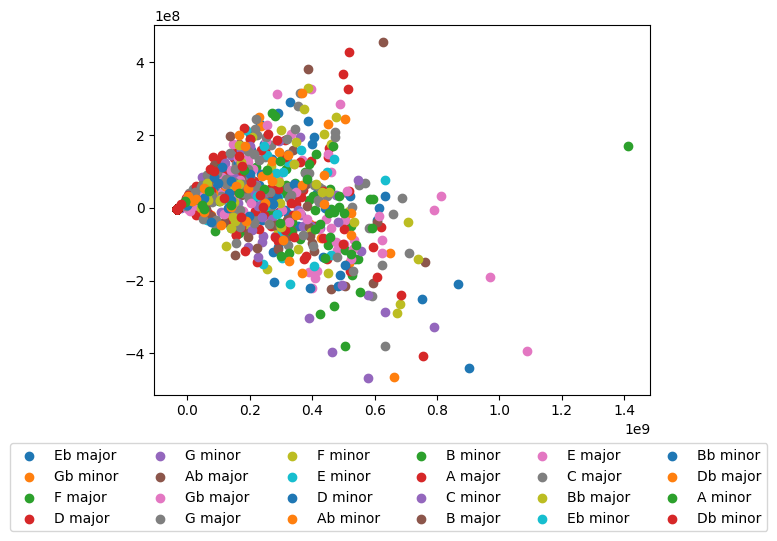

In [7]:
# PCA for initial visualization
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(X_train)

transformed_df = pd.DataFrame(transformed_data, columns=["x", "y"])
transformed_df = transformed_df.join(y_train)

fig = plt.figure()
ax = fig.add_subplot()
for key in all_keys:
  samples = transformed_df[transformed_df["target"] == key]
  ax.scatter(x=samples["x"], y=samples["y"], label=key)
plt.legend(loc='right', bbox_to_anchor=(1.25, -0.25), ncol=6)

### Machine Learning Approach 1:
### Logistic Regression Full Key Classification

In [8]:
# Running this should take about 10 Minutes

log_reg = LogisticRegression()

# Use grid search to find the best regularization for the data
param_grid = {
    'C': [1, 10, 1000, 10000]
}
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

log_reg = LogisticRegression(C=best_params["C"])

C:\Users\Zachary\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Zachary\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

In [9]:
log_reg.fit(X_train, y_train)
log_reg_results = log_reg.predict(X_test)

def conf_matrix_to_df(conf_matrix, target_names):
    return pd.DataFrame(conf_matrix, columns=target_names, index=target_names)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=log_reg_results)
conf_matrix_to_df(conf_matrix, all_keys)

C:\Users\Zachary\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Eb major,Gb minor,F major,D major,G minor,Ab major,Gb major,G major,F minor,E minor,...,C minor,B major,E major,C major,Bb major,Eb minor,Bb minor,Db major,A minor,Db minor
Eb major,94,5,0,0,0,1,0,0,0,0,...,3,1,0,0,0,0,0,0,0,2
Gb minor,5,75,0,3,0,0,0,0,5,0,...,0,2,0,0,3,0,3,1,0,0
F major,0,0,50,2,0,0,0,2,0,2,...,0,0,2,2,0,7,0,0,0,2
D major,0,0,2,43,4,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
G minor,0,0,0,1,73,3,0,1,0,0,...,6,0,0,0,0,0,0,0,3,1
Ab major,1,0,0,0,7,34,0,0,0,0,...,1,5,0,0,0,0,1,0,0,0
Gb major,0,0,0,0,1,0,86,3,0,6,...,0,0,9,0,5,1,0,3,0,0
G major,0,0,0,0,0,0,2,37,0,1,...,0,0,1,0,1,4,0,0,0,0
F minor,0,2,0,0,0,0,0,2,116,5,...,0,0,0,0,8,1,5,1,0,0
E minor,0,0,0,0,0,0,5,1,2,62,...,0,0,6,0,0,1,0,2,0,0


Text(0.5, 1.0, 'Confusion Matrix Heat Map')

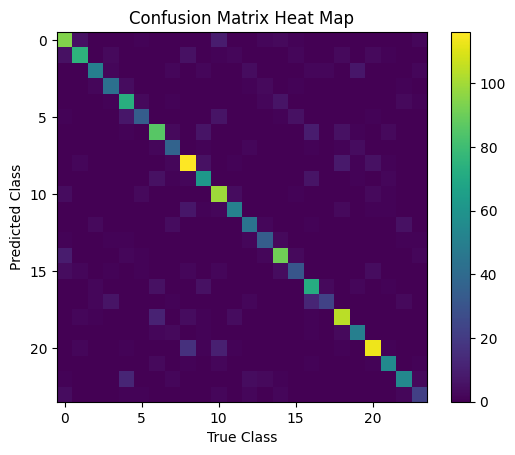

In [10]:
plt.imshow(conf_matrix)
plt.colorbar(location="right")
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.title("Confusion Matrix Heat Map")

In [11]:
print(classification_report(y_true=y_test, y_pred=log_reg_results))

              precision    recall  f1-score   support

     A major       0.76      0.80      0.78       117
     A minor       0.85      0.75      0.80       100
    Ab major       0.83      0.68      0.75        73
    Ab minor       0.75      0.78      0.77        55
     B major       0.72      0.81      0.76        90
     B minor       0.77      0.62      0.69        55
    Bb major       0.75      0.75      0.75       114
    Bb minor       0.66      0.77      0.71        48
     C major       0.76      0.82      0.79       141
     C minor       0.73      0.78      0.76        79
     D major       0.74      0.86      0.80       115
     D minor       0.81      0.77      0.79        66
    Db major       0.72      0.75      0.73        59
    Db minor       0.71      0.77      0.74        44
     E major       0.82      0.83      0.82       110
     E minor       0.70      0.61      0.65        51
    Eb major       0.68      0.80      0.73        90
    Eb minor       0.82    

### Machine Learning Approach 2:
### Shallow Fully Connected Neural Network

In [12]:
NUM_CLASSES = len(all_keys)
all_keys_int = [i for i, key in enumerate(all_keys)]
KEY_IDS = dict(zip(all_keys, all_keys_int))

# Split the training data into train and validation
xtrain, xval, ytrain, yval = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
xtrain = normalize(xtrain)
xval = normalize(xval)
xtest_nn = normalize(X_test)
ytest = y_test

# Use SMOTE to augment the training data
sm = SMOTE(random_state=42)
xtrain, ytrain = sm.fit_resample(X=xtrain, y=ytrain)

# Convert the labels to integers
ytrain = ytrain.replace(to_replace=KEY_IDS)
yval = yval.replace(to_replace=KEY_IDS)
ytest = ytest.replace(to_replace=KEY_IDS)
# Map the targets to 1-Hot encoding of all 24 classes
ytrain_1hot = to_categorical(ytrain, num_classes=NUM_CLASSES)
yval_1hot = to_categorical(yval, num_classes=NUM_CLASSES)
ytest_1hot = to_categorical(ytest, num_classes=NUM_CLASSES)

print(f'X Train Shape: {xtrain.shape}, Y Train Shape: {ytrain_1hot.shape}')
print(f'X Val Shape: {xval.shape}, Y Val Shape: {yval_1hot.shape}')
print(f'X Test Shape: {xtest_nn.shape}, Y Test Shape: {ytest_1hot.shape}')

X Train Shape: (11808, 5000), Y Train Shape: (11808, 24)
X Val Shape: (1576, 5000), Y Val Shape: (1576, 24)
X Test Shape: (1970, 5000), Y Test Shape: (1970, 24)


In [13]:
l2_reg = 0.0005
def neural_network_train():
    layers = [
        Flatten(),
        Dense(25,
              activation="relu",
              kernel_regularizer=L2(l2_reg)
        ),
        Dense(25,
              activation="relu",
              kernel_regularizer=L2(l2_reg)
        ),
        Dropout(0.1),
        Dense(NUM_CLASSES, activation="softmax")
    ]

    model = Sequential(layers)
    opt = optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['acc'])

    return model

nn_model = neural_network_train()

Epoch 1/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.0620 - loss: 3.2064 - val_acc: 0.1009 - val_loss: 3.1668
Epoch 2/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.1121 - loss: 3.1490 - val_acc: 0.1434 - val_loss: 3.1054
Epoch 3/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.1429 - loss: 3.0828 - val_acc: 0.1567 - val_loss: 3.0292
Epoch 4/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.1570 - loss: 3.0018 - val_acc: 0.1789 - val_loss: 2.9443
Epoch 5/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.1811 - loss: 2.9102 - val_acc: 0.2145 - val_loss: 2.8465
Epoch 6/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.2161 - loss: 2.8095 - val_acc: 0.2456 - val_loss: 2.7527
Epoch 7/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.2383 - loss: 2.6998 - val_acc: 0.2817 - val_loss: 2.6554
Epoch 8/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.2497 - loss: 2.6110 - val_acc: 0.2900 - val_loss: 2.5596
Epoch 9/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.2669

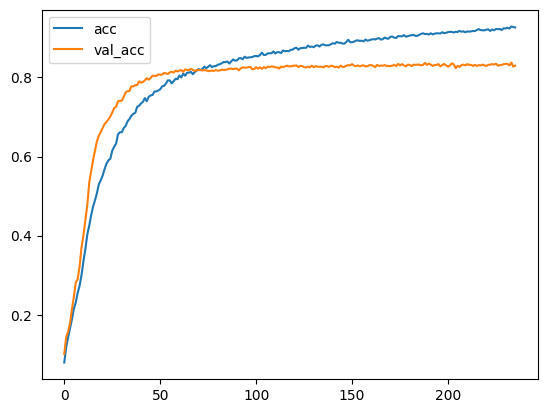

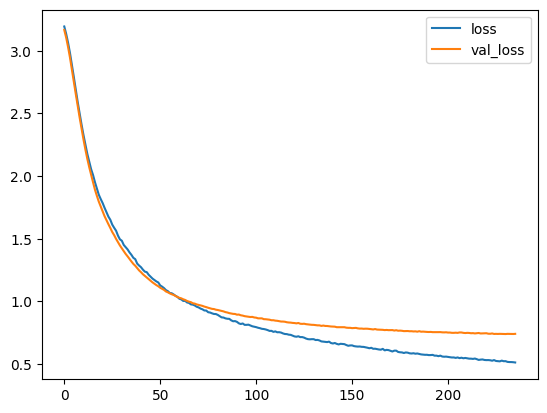

In [14]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
nn_history = nn_model.fit(xtrain,
                        ytrain_1hot,
                        batch_size=128,
                        epochs=500,
                        validation_data=(xval, yval_1hot),
                        callbacks=[early_stop])

plt.figure(0)
plt.plot(nn_history.history['acc'], label="acc")
plt.plot(nn_history.history['val_acc'], label="val_acc")
plt.legend()
plt.show()

plt.figure(1)
plt.plot(nn_history.history['loss'], label="loss")
plt.plot(nn_history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - acc: 0.8114 - loss: 0.8127
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
              precision    recall  f1-score   support

           0       0.76      0.86      0.81        90
           1       0.74      0.81      0.77        36
           2       0.86      0.82      0.84       128
           3       0.80      0.78      0.79       115
           4       0.79      0.88      0.83        64
           5       0.79      0.77      0.78        73
           6       0.83      0.71      0.77        80
           7       0.86      0.78      0.82       146
           8       0.79      0.83      0.81        60
           9       0.73      0.80      0.77        51
          10       0.74      0.80      0.77        66
          11       0.83      0.87      0.85        55
          12       0.79      0.75      0.77        55
          13       0.87      0.77      0.81       117
          14       0.81      0.75      0.78        79
          15       0.77

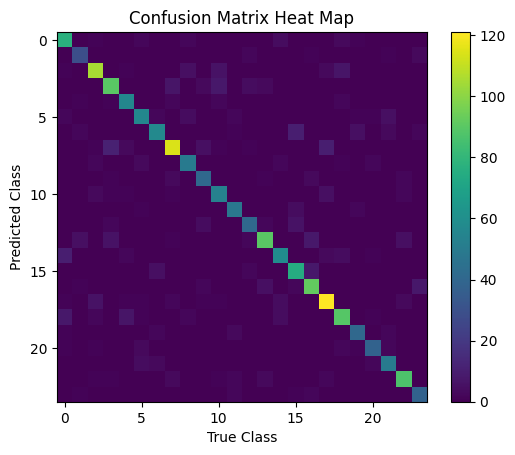

In [15]:
nn_model.evaluate(xtest_nn, ytest_1hot)

ypredict = nn_model.predict(xtest_nn)
yclasses = ypredict.argmax(axis=-1)
conf_matrix = confusion_matrix(y_true=ytest, y_pred=yclasses)

plt.figure(2)
plt.imshow(conf_matrix, cmap="viridis")
plt.colorbar(location="right")
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.title("Confusion Matrix Heat Map")

print(classification_report(y_true=ytest, y_pred=yclasses))

### Machine Learning Approach 3:
### Convolutional Neural Network

In [16]:
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = retrieve_data(square_data=True)

NUM_CLASSES = len(all_keys)
all_keys_int = [i for i, key in enumerate(all_keys)]
KEY_IDS = dict(zip(all_keys, all_keys_int))

# Split the training data into train and validation
xtrain, xval, ytrain, yval = train_test_split(X_train_cnn, y_train_cnn, test_size=0.2, random_state=42)
xtrain = normalize(xtrain)
xval = normalize(xval)
xtest_cnn = normalize(X_test_cnn)
ytest = y_test_cnn

# Use SMOTE to augment the training data
sm = SMOTE(random_state=42)
xtrain, ytrain = sm.fit_resample(X=xtrain, y=ytrain)

# Convert the labels to integers
ytrain = ytrain.replace(to_replace=KEY_IDS)
yval = yval.replace(to_replace=KEY_IDS)
ytest = ytest.replace(to_replace=KEY_IDS)
# Map the targets to 1-Hot encoding of all 24 classes
ytrain_1hot = to_categorical(ytrain, num_classes=NUM_CLASSES)
yval_1hot = to_categorical(yval, num_classes=NUM_CLASSES)
ytest_1hot = to_categorical(ytest, num_classes=NUM_CLASSES)

# Reshape all x sets
xtrain = xtrain.reshape(-1, 70, 70, 1)
xval = xval.reshape(-1, 70, 70, 1)
xtest_cnn = xtest_cnn.reshape(-1, 70, 70, 1)

print(f'X Train Shape: {xtrain.shape}, Y Train Shape: {ytrain_1hot.shape}')
print(f'X Val Shape: {xval.shape}, Y Val Shape: {yval_1hot.shape}')
print(f'X Test Shape: {xtest_cnn.shape}, Y Test Shape: {ytest_1hot.shape}')

X Train Shape: (11808, 70, 70, 1), Y Train Shape: (11808, 24)
X Val Shape: (1576, 70, 70, 1), Y Val Shape: (1576, 24)
X Test Shape: (1970, 70, 70, 1), Y Test Shape: (1970, 24)


In [17]:
# Defining the CNN architecture . . .
cnn_model = Sequential([
    Input(shape=(70, 70, 1)),
    Conv2D(32, kernel_size=(12, 12), strides=(2, 2), activation='relu'),
    Conv2D(64, kernel_size=(5, 5), strides=(1, 2), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(1024, activation='relu', kernel_regularizer=L2(0.05)),
    Dropout(0.25),
    Dense(NUM_CLASSES, activation='softmax')
])

lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=2000,
    decay_rate=0.95,
    staircase=True)

optimizer = optimizers.Adam(learning_rate=lr_schedule)
cnn_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['acc'])

cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 13, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 6, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4992)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     5,112,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 24)             │        24,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,193,336 (19.81 MB)

 Trainable params: 5,193,336 (19.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - acc: 0.1125 - loss: 27.3433 - val_acc: 0.5615 - val_loss: 1.9468
Epoch 2/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - acc: 0.6659 - loss: 1.6993 - val_acc: 0.7088 - val_loss: 1.4187
Epoch 3/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - acc: 0.7552 - loss: 1.3243 - val_acc: 0.7056 - val_loss: 1.3740
Epoch 4/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - acc: 0.7898 - loss: 1.1626 - val_acc: 0.7341 - val_loss: 1.1929
Epoch 5/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - acc: 0.8057 - loss: 1.0335 - val_acc: 0.7354 - val_loss: 1.1719
Epoch 6/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - acc: 0.8075 - loss: 0.9928 - val_acc: 0.7595 - val_loss: 1.1034
Epoch 7/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - acc: 0.8189 - loss: 0.9410 - val_acc: 0.7341 - val_loss: 1.1604
Epoch 8/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - acc: 0.8226 - loss: 0.9109 - val_acc: 0.7722 - val_loss: 1.0734
Epoch 9/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 10

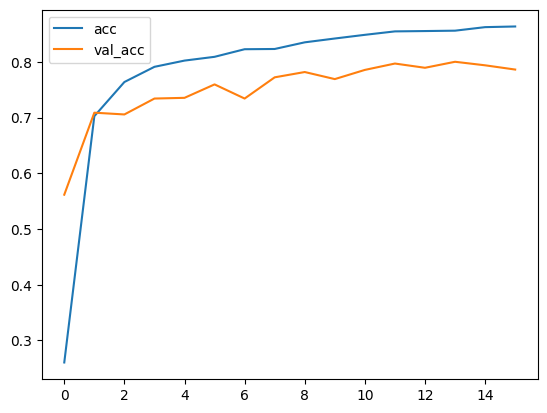

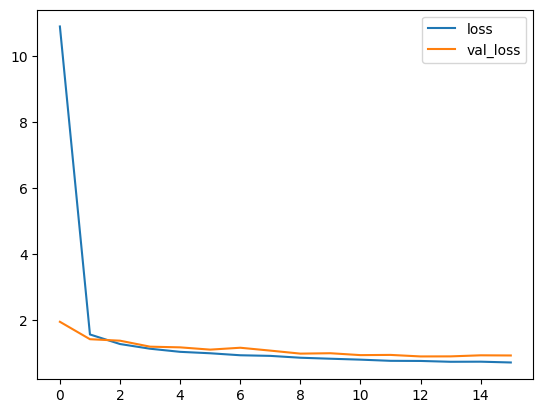

In [18]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = cnn_model.fit(xtrain,
                    ytrain_1hot,
                    validation_data=(xval, yval_1hot),
                    epochs=50,
                    batch_size=64,
                    callbacks=[early_stop]
)

plt.figure(0)
plt.plot(history.history['acc'], label="acc")
plt.plot(history.history['val_acc'], label="val_acc")
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.7960 - loss: 0.9223
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        90
           1       0.66      0.75      0.70        36
           2       0.78      0.88      0.83       128
           3       0.89      0.67      0.76       115
           4       0.84      0.75      0.79        64
           5       0.85      0.62      0.71        73
           6       0.68      0.86      0.76        80
           7       0.85      0.69      0.76       146
           8       0.81      0.80      0.81        60
           9       0.67      0.82      0.74        51
          10       0.77      0.82      0.79        66
          11       0.76      0.91      0.83        55
          12       0.85      0.71      0.77        55
          13       0.83      0.80      0.82       117
          14       0.92      0.76      0.83        79
          15       0.95     

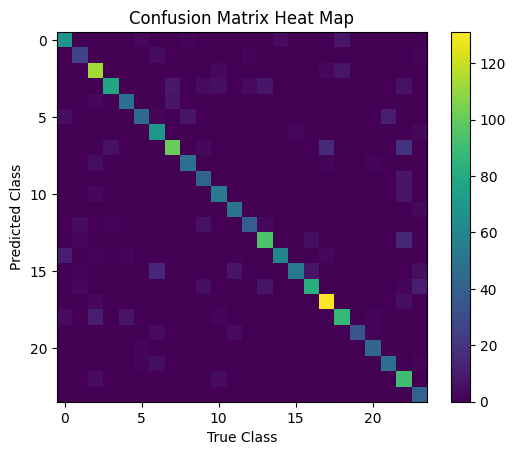

In [19]:
cnn_model.evaluate(xtest_cnn, ytest_1hot)

ypredict = cnn_model.predict(xtest_cnn)
yclasses = ypredict.argmax(axis=-1)
conf_matrix = confusion_matrix(y_true=ytest, y_pred=yclasses)

plt.figure(2)
plt.imshow(conf_matrix, cmap="viridis")
plt.colorbar(location="right")
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.title("Confusion Matrix Heat Map")

print(classification_report(y_true=ytest, y_pred=yclasses))

### Ensemble Approach

In [67]:
# Build a custom voting classifier for the pretrained models and their particular inputs
class KeyVotingClassifier:
    def __init__(self, models: dict):
        self.models = models

    def __predict(self, inputs):
        """
        Gives probabilistic predictions for each classifier
        using the given test inputs. Compiles into one array
        """
        # Order log reg keys
        self.models["log_reg"].classes_ = np.array(list(KEY_IDS.keys()))

        # Get the probabilities for each model
        pred_log_reg = self.models["log_reg"].predict_proba(inputs["log_reg"])
        pred_nn = self.models["nn"].predict(inputs["nn"])
        pred_cnn = self.models["cnn"].predict(inputs["cnn"])

        return np.array([pred_log_reg, pred_nn, pred_cnn])

    def soft_vote(self, inputs: dict):
        """
        Predicts the output classes of test data using soft voting
        with the estimator models given.
        """
        pred_avg = np.mean(self.__predict(inputs), axis=0)
        pred = np.apply_along_axis(lambda x: np.argmax(x), axis=1, arr=pred_avg)
        return pred

    def hard_vote(self, inputs: dict):
        """
        Predicts the output class of the test data using hard voting
        with the estimator models given.
        """
        pred_votes = np.apply_along_axis(lambda x: np.argmax(x), axis=2, arr=self.__predict(inputs))
        pred = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=pred_votes)
        return pred


In [69]:
classifiers = {"log_reg": log_reg, "nn": nn_model, "cnn": cnn_model}
ensemble = KeyVotingClassifier(classifiers)
test_inputs = {"log_reg": X_test, "nn": xtest_nn, "cnn": xtest_cnn}

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

           0       0.53      0.89      0.67        90
           1       0.48      0.81      0.60        36
           2       0.71      0.90      0.79       128
           3       0.74      0.78      0.76       115
           4       0.50      0.88      0.64        64
           5       0.68      0.64      0.66        73
           6       0.69      0.76      0.73        80
           7       0.81      0.79      0.80       146
           8       0.67      0.77      0.71        60
           9       0.62      0.80      0.70        51
          10       0.82      0.77      0.80        66
          11       0.83      0.82      0.83        55
          12       0.87      0.60      0.71        55
          13       0.87      0.65      0.75       117
          14       0.79      0.68      0.73        79
          15       0.93      0.57      0.70        90
 

Text(0.5, 1.0, 'Hard Voting Confusion Matrix Heat Map')

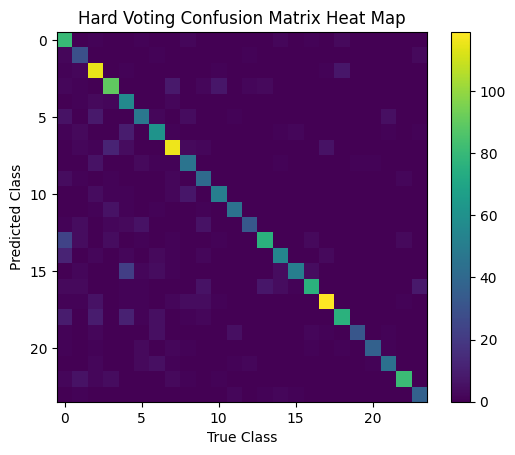

In [71]:
pred_hard = ensemble.hard_vote(test_inputs)
print(classification_report(y_true=ytest, y_pred=pred_hard))
conf_matrix = confusion_matrix(y_true=ytest, y_pred=pred_hard)
plt.figure(0)
plt.imshow(conf_matrix, cmap="viridis")
plt.colorbar(location="right")
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.title("Hard Voting Confusion Matrix Heat Map")

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

           0       0.75      0.79      0.77        90
           1       0.77      0.75      0.76        36
           2       0.87      0.85      0.86       128
           3       0.85      0.71      0.77       115
           4       0.72      0.75      0.73        64
           5       0.80      0.71      0.75        73
           6       0.75      0.84      0.79        80
           7       0.91      0.74      0.82       146
           8       0.72      0.83      0.78        60
           9       0.69      0.78      0.73        51
          10       0.66      0.79      0.72        66
          11       0.85      0.95      0.90        55
          12       0.91      0.75      0.82        55
          13       0.87      0.76      0.81       117
          14       0.89      0.78      0.83        79
          15       0.90      0.72      0.80        90
 

Text(0.5, 1.0, 'Soft Voting Confusion Matrix Heat Map')

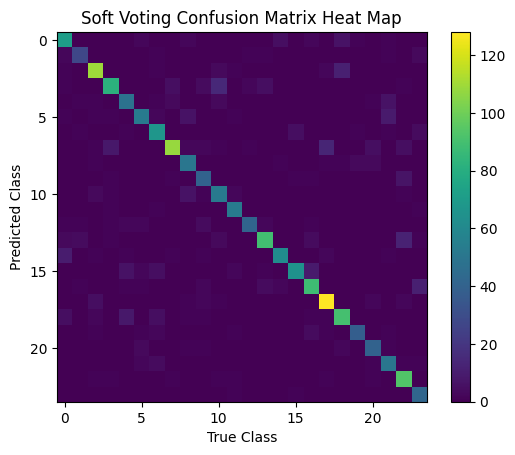

In [72]:
pred_soft = ensemble.soft_vote(test_inputs)
print(classification_report(y_true=ytest, y_pred=pred_soft))
conf_matrix = confusion_matrix(y_true=ytest, y_pred=pred_soft)
plt.figure(1)
plt.imshow(conf_matrix, cmap="viridis")
plt.colorbar(location="right")
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.title("Soft Voting Confusion Matrix Heat Map")